<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/VMIM-vs-MSE/blob/main/VMIM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Packages 

In [1]:
!pip install --quiet jax-cosmo numpyro dm-haiku==0.0.5 optax
!pip install --quiet git+https://github.com/EiffL/powerbox-jax.git@numpyro
!pip install --quiet git+https://github.com/astrodeepnet/sbi_experiments.git

     |████████████████████████████████| 283 kB 8.0 MB/s 
     |████████████████████████████████| 282 kB 63.1 MB/s 
     |████████████████████████████████| 287 kB 68.8 MB/s 
     |████████████████████████████████| 136 kB 78.7 MB/s 
     |████████████████████████████████| 65 kB 3.4 MB/s 
     |████████████████████████████████| 109 kB 7.0 MB/s 


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import jax
import jax_cosmo as jc
import jax.numpy as jnp

import numpyro
from numpyro.handlers import seed, trace, condition
import numpyro.distributions as dist

import powerbox_jax as pbj

import haiku as hk
import optax

In [4]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

### WL model

In [11]:
def model(N=64,                # number of pixels on the map
          map_size=10,         # map size in deg.
          gal_per_arcmin2=50,   
          sigma_e=0.2):      
    
    pix_area = (map_size * 60 / N)**2 # arcmin2 
    map_size = map_size / 180 * pi    # radians

    
    # Sampling cosmology
    omega_c = numpyro.sample('omega_c', dist.Normal(0.3, 0.05))
    sigma_8 = numpyro.sample('sigma_8', dist.Normal(0.8, 0.05))
    
    cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma_8)
    # Creating a given redshift distribution
    pz = jc.redshift.smail_nz(0.5, 2., 1.0)
    tracer = jc.probes.WeakLensing([pz])
    
    # Defining the function that will compute the power spectrum of the field
    # Create an interpolation array for the cls to avoid far too many computations
    ell_tab = jnp.logspace(0, 4.5, 128)
    cell_tab = jc.angular_cl.angular_cl(cosmo, ell_tab, [tracer], nonlinear_fn=jc.power.linear)[0]
    # Warning!!!!: I was too lazy to figure out the proper conversion from k to ell 
    P = lambda k: jc.scipy.interpolate.interp(k.flatten(), ell_tab, cell_tab).reshape(k.shape)
    
    pb = pbj.PowerBox(
        N=N,                                   # Number of grid-points in the box
        dim=2,                                 # 2D box
        pk = P,                                # The power-spectrum
        boxlength = map_size,                  # Size of the box (sets the units of k in pk)
        vol_normalised_power=True,             # normalise power by volume
        supplied_freqs=None
    )
      
    # Sampling field
    field = pb.delta_x()
    
    # Adding "observational noise"
    x = numpyro.sample('x', dist.Independent(dist.Normal(field, sigma_e/jnp.sqrt(gal_per_arcmin2 * pix_area)), 2))
    
    return x

In [12]:
sample_map = seed(model, jax.random.PRNGKey(0))

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:6493: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


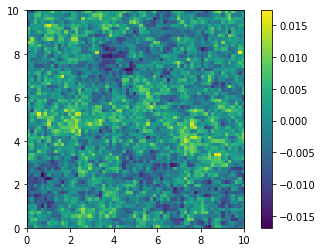

In [13]:
m = sample_map()
imshow(m, extent=(0,10,0,10))
colorbar()
show()

In [14]:
# Create our fiducial observations
fiducial_model = condition(model, {'omega_c': 0.27, 'sigma_8': 0.77})
sample_map_fiducial = seed(fiducial_model, jax.random.PRNGKey(12345670))
m_data = sample_map_fiducial()

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:6493: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


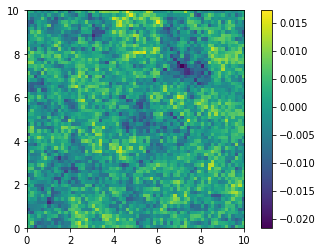

In [15]:
imshow(m_data, extent=(0,10,0,10))
colorbar()
show()

### Training a neural network to learn a good summary stat ( compressor )

⚠️ this is the important part 


To do ML you need: 


*   data 
*   a model 
*   an optimizer 
*   a loss 


When you have defined all this you can train your model on your data by minimizing your loss using your optimizer.




###### data 

In [16]:
# Now we define a model conditioned on these values
def eval_model(key):

  cond_model = seed(model, key)
  model_trace = trace(cond_model).get_trace()
  
  return jnp.array([model_trace['omega_c']['value'], model_trace['sigma_8']['value'] ]) , model_trace['x']['value']

In [17]:
@jax.jit
def get_batch_compressor(key, batch_size=128):

  p, x = jax.vmap(eval_model)(jax.random.split(key, batch_size))
  
  return p, x

In [18]:
master_seed = hk.PRNGSequence(42)
p, x = get_batch_compressor(next(master_seed))
# p = omega_c and sigma_8
# x = observation

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:6493: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


###### model

In [19]:
# This is a CNN that compresses the shear map into 2 statistics. 

class Compressor(hk.Module):

  def __call__(self, x):
    # x = shear map 
    x = x[..., jnp.newaxis]
    net_x = hk.Conv2D(32, 3, 2)(x) # 2d convolutional layer with 32 filters, 3 by 3 kernel, stride = 2 (the step) 
    net_x = jax.nn.leaky_relu(net_x) # activation function = leaky relu
    net_x = hk.Conv2D(64, 3, 2)(net_x) 
    net_x = jax.nn.leaky_relu(net_x) 
    net_x = hk.Conv2D(128, 3, 2)(net_x)
    net_x = jax.nn.leaky_relu(net_x) 
    net_x = hk.AvgPool(16,8,'SAME')(net_x) # pooling layer: it averages a 16 by 16 window with stride = 8
    net_x = hk.Flatten()(net_x) # flatten layer

    # Bottleneck
    net_x = hk.Linear(2)(net_x) # linear layer : net_x * weight + bias 
    # it return the  2 statistics

    return net_x.squeeze()

In [21]:
# hk.transform() -> Transforms a function using Haiku modules into a pair of pure functions : init() and apply()
# - init() : The init function, with signature params = init(rng, ...) (where '...' are the arguments to the untransformed function), 
#            allows you to collect the initial value of any parameters in the network. Haiku does this by running your function, 
#            keeping track of any parameters requested through hk.get_parameter (called by e.g. hk.Linear) and returning them to you.
# - apply() : The apply function, with signature result = apply(params, rng, ...), allows you to inject parameter values into your function.

12
# create the compressor method
compressor = hk.without_apply_rng(hk.transform(lambda x : Compressor()(x)))

# init the params of the model
rng_seq = hk.PRNGSequence(0)
params_compressor = compressor.init(next(rng_seq), jnp.zeros([1,64,64]))

###### optimizer

In [22]:
learning_rate=0.001 # this is the step size (you usually decrease it during training)

optimizer = optax.adam(learning_rate)

# we initialize the optimizer with the parameters of the compressor
# to obtain `opt_state` that contains statistics for the optimizer
opt_state = optimizer.init(params_compressor)

###### loss

In [23]:
def loss_fn(params, batch):

  # here we feed the compressor with the shear map 'x' and get the 2 stats 'out'  
  # to do this we use the apply() function, give the params of the cnn and our input x
  out = jax.vmap(lambda p, x: compressor.apply(params, x.reshape([-1,64,64])))(*batch)

  # to get 'good' statistics from the shear map, we train the cnn
  # to predict statistics close to omega_c and sigma_8
  # -> mean(norm((x1-x2)-(omega_c, sigma_8))**2)  with (x1,x2)=out
  loss = jnp.mean(jnp.sum((out - batch[0])**2, axis=1))

  return loss

###### training 



one update step:



*  (1) we feed the compressor with our data 
*  (2) we evaluate the loss for these data and get the gradients
*  (3) thanks to these gradients we update the CNN params


In [24]:
@jax.jit
def update(params, opt_state, batch):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params, batch) # (1) and (2)
    updates, new_opt_state = optimizer.update(grads, opt_state) # (3)
    new_params = optax.apply_updates(params, updates) # (3)
    # new_params = new params of the compressor after the update

    return loss, new_params, new_opt_state

In [25]:
from tqdm import tqdm
losses = []
master_seed = hk.PRNGSequence(0)

We can now train the compressor.

We start with a 'big' learning rate = 0.001 to converge quickly and not get stuck in local minimums. We update the compressor parameters 1000 times.

In [26]:
it = 1000

for step in tqdm(range(it)):
  p, x = get_batch_compressor(next(master_seed))
  l, params_compressor, opt_state = update(params_compressor, opt_state, (p, x))
  losses.append(l)

100%|██████████| 1000/1000 [00:46<00:00, 21.68it/s]


We decrease the learning rate (so we have to reset the optimizer but we use the last updated parameters of the cnn) and we update 10000 times the cnn parameters.

In [27]:
learning_rate=0.0001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params_compressor)

In [28]:
it = 10000

for step in tqdm(range(it)):
  p, x = get_batch_compressor(next(master_seed))
  l, params_compressor, opt_state = update(params_compressor, opt_state, (p, x))
  losses.append(l)

100%|██████████| 10000/10000 [07:27<00:00, 22.34it/s]


Text(0, 0.5, 'loss')

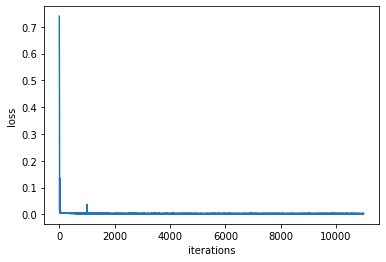

In [29]:
# this is the loss for each step
plt.plot(jnp.array(losses))
plt.xlabel('iterations')
plt.ylabel('loss')

In [30]:
p, x = get_batch_compressor(next(master_seed))
reg = compressor.apply(params_compressor, x)

Text(0, 0.5, 'first statistic')

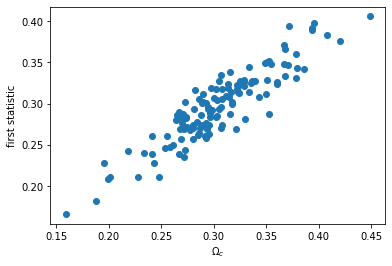

In [31]:
plt.scatter(p[:,0], reg[:,0])
plt.xlabel('$\Omega_c$')
plt.ylabel('first statistic')

Text(0, 0.5, 'second statistic')

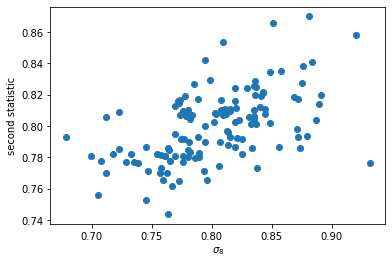

In [32]:
scatter(p[:,1], reg[:,1])
plt.xlabel('$\sigma_8$')
plt.ylabel('second statistic')

### Now that we have a compressor, let's try to learn the posterior

In [33]:
#Now we define a model conditioned on these values
def eval_model(params, key):
  oc = params[0]
  s8 = params[1]

  cond_model = condition(seed(model, key), {'omega_c': oc, 'sigma_8': s8})
  model_trace = trace(cond_model).get_trace()
  return model_trace['x']['value']

@jax.jit
def get_batch(key, batch_size=1000):

  # Randomly draw from the prior
  key1, key2, key3 = jax.random.split(key, 3)
  oc = tfd.Normal(0.3, 0.05).sample(batch_size, seed=key1)
  s8 = tfd.Normal(0.8, 0.05).sample(batch_size, seed=key2)
  params_ref = jnp.stack([oc,s8], axis=1)

  x = jax.vmap(eval_model)(params_ref,jax.random.split(key3, batch_size))
  
  return params_ref, x

In [34]:
from sbiexpt.bijectors import MixtureAffineSigmoidBijector 

In [35]:
d = 2

class CustomCoupling(hk.Module):
  """This is the coupling layer used in the Flow."""
  def __init__(self, y, *args, **kwargs):
    self.y = y
    super(CustomCoupling, self).__init__(*args, **kwargs)

  def __call__(self, x, output_units, **condition_kwargs):

    net = jnp.concatenate([x, self.y], axis=-1)
    # NN to get a b and c
    net = hk.Linear(128, name='l1')(net)
    net = jax.nn.silu(net) # silu = x*sigmoid(x)
    net = hk.Linear(128, name='l2')(net)
    net = jax.nn.silu(net)
    
    log_a_bound=4
    min_density_lower_bound=1e-4
    n_components = 16
    
    log_a = jax.nn.tanh(hk.Linear(output_units*n_components, name='l3')(net)) * log_a_bound
    b   = hk.Linear(output_units*n_components, name='l4')(net)
    c   = min_density_lower_bound + jax.nn.sigmoid(hk.Linear(output_units*n_components, name='l5')(net)) * (1 - min_density_lower_bound)
    p   = jax.nn.softmax(hk.Linear(n_components, name='l6')(net))
    return MixtureAffineSigmoidBijector(jnp.exp(log_a),b,c, p)

class Flow(hk.Module):
    """A normalizing flow using the coupling layers defined
    above."""
    def __call__(self, y):
      chain = tfb.Chain([
            tfb.RealNVP(d//2, bijector_fn=CustomCoupling(y, name = 'b1')),
            tfb.Permute([1,0]),
            tfb.RealNVP(d//2, bijector_fn=CustomCoupling(y, name = 'b2')),
            tfb.Permute([1,0]),
        ])
      
      nvp = tfd.TransformedDistribution(
            tfd.MultivariateNormalDiag(jnp.array([0.3,0.8]), scale_identity_multiplier=0.05),
            bijector=chain)
      return nvp

In [36]:
nvp = hk.without_apply_rng(hk.transform(lambda p,y : Flow()(y).log_prob(p).squeeze()))

In [37]:
def loss_fn(params, batch):
  y = compressor.apply(params_compressor, batch[1])
  log_prob = jax.vmap(lambda p, x: nvp.apply(params, p.reshape([-1,2]), x.reshape([-1,2])))(batch[0], y) # Here we extract the grad of the model
  return -jnp.mean(log_prob)

@jax.jit
def update(params, opt_state, batch):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:6493: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
100%|██████████| 10000/10000 [01:52<00:00, 88.90it/s]


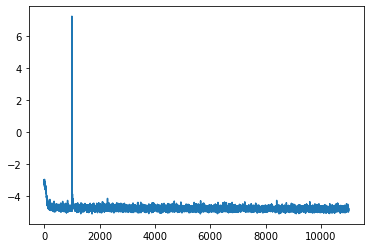

In [38]:
nb_simu = 1000
size_mini_batch = 100


# init model 
rng_seq = hk.PRNGSequence(12)
params = nvp.init(next(rng_seq), jnp.zeros([1, 2]), jnp.zeros([1,2]))

losses = []
master_seed = hk.PRNGSequence(0)


# training 
learning_rate=0.001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

p, x = get_batch(jax.random.PRNGKey(0))

it = 1000
for step in tqdm(range(it)):
  inds = np.random.randint(0, nb_simu, size_mini_batch)
  # p, x, score = get_batch(next(master_seed))
  l, params, opt_state = update(params, opt_state, (p[inds], x[inds]))
  losses.append(l)

learning_rate=0.0001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

it = 10000
for step in tqdm(range(it)):
  inds = np.random.randint(0, nb_simu, size_mini_batch)
  l, params, opt_state = update(params, opt_state, (p[inds], x[inds]))
  losses.append(l)

plot(array(losses)[:])

In [39]:
p = jnp.stack(jnp.meshgrid(jnp.linspace(0.2,0.4,64),
                 jnp.linspace(0.7,0.9,64)), axis=-1)
ps = p.reshape([-1, 2])

y = compressor.apply(params_compressor,  m_data.reshape((1,64,64)).repeat(len(ps),axis=0))
pred_fn = nvp.apply(params, ps, y).reshape([64, 64])

Text(0, 0.5, '$\\sigma_8$')

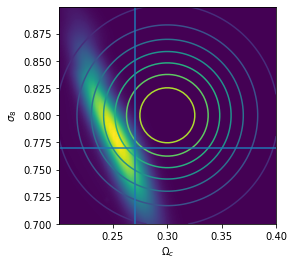

In [40]:
contourf(p[...,0], p[...,1], jnp.exp(pred_fn - pred_fn.max()), 256); 
contour(p[...,0], p[...,1], tfd.MultivariateNormalDiag([0.3,0.8], scale_identity_multiplier=0.05).prob(ps).reshape([64, 64]))
axvline(0.27)
axhline(0.77)
gca().set_aspect('equal')
xlabel('$\Omega_c$')
ylabel('$\sigma_8$')